In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
import gc

import datetime
# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math

import textwrap
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
import pydotplus
from IPython.display import Image
from graphviz import Digraph
from sklearn import tree


pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)


In [2]:
df = pd.read_csv("../data/viewing_rating.csv", encoding='cp932')

In [3]:
# time型に
df.start_at=pd.to_datetime(df.start_at)
# averageの％を削除
df["average"] =  df["average"].apply(lambda x : float(x[:-1]) )


In [4]:
df["start_at_year"] = df["start_at"].dt.year
df["start_at_month"] = df["start_at"].dt.month

In [5]:
df["drama_key"] = df.start_at.dt.strftime("%y")+df.start_at.dt.strftime("%m")+"_"+df.TV_station+"_"+df.time_table

In [6]:
import json

f = open("../data/drama_info0115.json", 'r')
print(f)
drama_info_json = json.load(f)

<_io.TextIOWrapper name='../data/drama_info0115.json' mode='r' encoding='UTF-8'>


In [7]:
# def addDramaInfo (drama_title) 
#     main_actor_only_json[drama_title]
    


In [8]:
print (textwrap.shorten(str(drama_info_json), 1000))

{'1910_CX_月21': {'main_actor1': 'ディーン・フジオカ', 'main_actor2': '岩田剛典', 'original_work': 'アーサー・コナン・ドイル「シャーロック・ホームズ」'}, '1910_CX_火22': {'main_actor1': '阿部寛', 'main_actor2': '吉田羊', 'original_work': ''}, '1910_TBS_火22': {'main_actor1': '波瑠', 'main_actor2': '中川大志', 'original_work': 'いくえみ綾「G線上のあなたと私」'}, '1910_NTV_水22': {'main_actor1': '高畑充希', 'main_actor2': '橋本愛', 'original_work': ''}, '1910_EX_木21': {'main_actor1': '米倉涼子', 'main_actor2': 'ユースケ・サンタマリア', 'original_work': ''}, '1910_CX_木22': {'main_actor1': '新木優子', 'main_actor2': '高良健吾', 'original_work': '瀧波ユカリ「モトカレマニア」'}, '1910_NTV_木23': {'main_actor1': '本田翼', 'main_actor2': '金子大地', 'original_work': ''}, '1910_TBS_金22': {'main_actor1': '福士蒼汰', 'main_actor2': '菜々緒', 'original_work': 'キリエ「4分間のマリーゴールド」'}, '1910_EX_金23': {'main_actor1': 'オダギリジョー', 'main_actor2': '麻生久美子', 'original_work': ''}, '1910_NTV_土22': {'main_actor1': '生田斗真', 'main_actor2': '安田顕', 'original_work': ''}, '1910_EX_土23': {'main_actor1': '田中圭', 'main_actor2': '吉田鋼太郎', [...]


In [9]:
df["main_actor1"] = ""
df["main_actor2"] = ""
df["original_work"] = ""

In [10]:
for tmp_index in range(len(df)):
    tmp_drama_key = df.iloc[tmp_index]["drama_key"]
    if tmp_drama_key in drama_info_json.keys():
#         print(drama_info_json[tmp_drama_key]["main_actor1"])
        df["main_actor1"][tmp_index] = drama_info_json[tmp_drama_key]["main_actor1"]
        df["main_actor2"][tmp_index] = drama_info_json[tmp_drama_key]["main_actor2"]
        df["original_work"][tmp_index] = drama_info_json[tmp_drama_key]["original_work"]
#         print("yes"+tmp_drama_title)
    else:
        print(tmp_drama_key)

1910_EX_木22


In [11]:
def make_person_key_df (actor_actress):
    actor_actress_list = []
    for column in actor_actress.columns:
        if column == "ranking":
            continue
        actor_actress_list.extend(actor_actress[column].values.tolist())
    print ("元の数"+ str(len(actor_actress_list)))
    # uniqueにする
    actor_actress_list = list(set(actor_actress_list))
    #nan を除去
    actor_actress_list = [actor for actor in actor_actress_list if type(actor) is not float ]
    print ("後の数"+str(len(actor_actress_list)))

    df_pivot = pd.DataFrame( columns=actor_actress_list, index=[str(n) for n in range(2008,2020)])

    #pivot 形式に整形する
    for tmp_name in df_pivot.columns:
        for year in actor_actress.columns:
            if year == "ranking": continue
            if  len(actor_actress[actor_actress[year] == tmp_name].ranking) > 0:
                df_pivot.loc[year][tmp_name] = (actor_actress[actor_actress[year] == tmp_name].ranking).values[0]
    return (df_pivot)
    

In [12]:
df_actress = pd.read_csv("../data/actress_power.csv", encoding='cp932')
df_actress_pivot = make_person_key_df(df_actress)


元の数360
後の数62


In [13]:
df_actor = pd.read_csv("../data/actor_power.csv", encoding='cp932')
df_actor_pivot = make_person_key_df(df_actor)

元の数372
後の数65


In [14]:
df_actress_pivot

,松下奈緒,真矢みき,有村架純,広瀬すず,木村文乃,広瀬アリス,多部未華子,芦田愛菜,石原さとみ,能年玲奈,戸田恵梨香,優香,小泉今日子,柴咲コウ,深津絵里,木村佳乃,榮倉奈々,菅野美穂,桐谷美玲,井上真央,仲間由紀恵,吉瀬美智子,吉永小百合,波瑠,上戸彩,観月ありさ,竹内結子,堀北真希,上野樹里,石田ゆり子,黒木メイサ,篠原涼子,長澤まさみ,常盤貴子,江角マキコ,米倉涼子,菜々緒,小雪,薬師丸ひろ子,黒木瞳,永作博美,藤原紀香,佐々木希,深田恭子,松嶋菜々子,土屋太鳳,松たか子,樹木希林,吉高由里子,山口智子,橋本環奈,吉田羊,新垣結衣,蒼井優,杏,北川景子,綾瀬はるか,宮_あおい,高畑充希,武井咲,柴崎コウ,天海祐希
2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010,NaN,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25,12,NaN,7,13,NaN,NaN,5,NaN,28,2,NaN,22,NaN,4,29,8,15,NaN,NaN,23,21,17,24,NaN,19,NaN,30,NaN,14,NaN,27,NaN,20,3,NaN,16,NaN,NaN,11,NaN,NaN,9,26,NaN,NaN,6,10,NaN,NaN,NaN,1
2011,23,20,NaN,NaN,NaN,NaN,NaN,NaN,21,NaN,NaN,NaN,16,4,11,NaN,NaN,1,NaN,27,5,NaN,22,NaN,3,24,13,14,18,NaN,7,12,NaN,NaN,NaN,26,NaN,NaN,NaN,30,29,NaN,NaN,17,8,NaN,19,NaN,NaN,28,NaN,NaN,10,25,NaN,15,2,9,NaN,NaN,NaN,6
2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,25,NaN,16,11,7,27,NaN,NaN,6,NaN,17,10,NaN,19,NaN,3,26,NaN,2,NaN,NaN,NaN,14,22,NaN,20,13,NaN,NaN,28,NaN,NaN,NaN,NaN,18,12,NaN,23,24,NaN,NaN,NaN,NaN,5,NaN,15,4,1,30,NaN,21,NaN,9
2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,17,NaN,19,24,6,28,NaN,NaN,15,29,20,3,27,25,NaN,10,NaN,16,2,30,NaN,NaN,13,22,NaN,NaN,9,NaN,NaN,NaN,NaN,NaN,NaN,21,18,14,NaN,11,NaN,26,NaN,NaN,NaN,5,NaN,7,4,1,NaN,NaN,23,NaN,8
2016,NaN,NaN,3,15,NaN,NaN,NaN,NaN,5,NaN,NaN,24,19,13,28,NaN,NaN,18,10,30,9,NaN,25,NaN,12,NaN,26,6,NaN,NaN,NaN,14,22,NaN,NaN,20,27,NaN,NaN,NaN,NaN,NaN,NaN,8,21,NaN,17,NaN,NaN,NaN,NaN,16,4,NaN,11,2,1,29,NaN,23,NaN,7
2017,NaN,NaN,6,11,NaN,NaN,24,NaN,3,NaN,NaN,NaN,27,NaN,25,NaN,26,17,9,28,7,NaN,NaN,NaN,12,NaN,29,15,NaN,20,NaN,10,16,NaN,NaN,18,NaN,NaN,NaN,NaN,NaN,NaN,30,5,22,19,NaN,NaN,21,NaN,NaN,NaN,1,NaN,14,4,2,NaN,NaN,23,13,8


In [15]:
df_actor_namekey = df_actor_pivot.T.rename_axis('actor_actress').reset_index()

In [16]:
df_actress_namekey = df_actress_pivot.T.rename_axis('actor_actress').reset_index()

In [17]:
df_actress_namekey

,actor_actress,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,松下奈緒,NaN,NaN,NaN,23,NaN,NaN,29,NaN,NaN,NaN,NaN,NaN
1,真矢みき,NaN,NaN,18,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,有村架純,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,6,6,6
3,広瀬すず,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,11,10,7
4,木村文乃,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24,NaN
5,広瀬アリス,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29,22
6,多部未華子,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24,22,14
7,芦田愛菜,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28,26
8,石原さとみ,NaN,NaN,NaN,21,NaN,NaN,8,12,5,3,3,5
9,能年玲奈,NaN,NaN,NaN,NaN,NaN,NaN,25,17,NaN,NaN,NaN,NaN


In [18]:
df_merged = pd.merge(df, df_actor_namekey,left_on='main_actor1', right_on='actor_actress', how='left')
#df_merged = pd.merge(df_merged, df_actress_namekey,left_on='main_actor1', right_on='actor_actress', how='right')
#df_merged = pd.merge(df_merged, df_actress_namekey,left_on='main_actor2', right_on='actor_actress', how='right')

In [19]:

df_merged = pd.merge(df_merged, df_actress_namekey,left_on='main_actor1', right_on='actor_actress', how='left'
                     ,suffixes=('_1', '_2'))

In [20]:

df_merged = pd.merge(df_merged, df_actor_namekey,left_on='main_actor2', right_on='actor_actress', how='left'
                     ,suffixes=('_3', '_4') )


In [21]:
df_merged = pd.merge(df_merged, df_actress_namekey,left_on='main_actor2', right_on='actor_actress', how='left'
                    , suffixes=('_3', '_4'),)

In [22]:
# df_merged[["main_actor1","2017","2016","2014"]]
df_merged

,TV_station,time_table,drama_title,Episode1,Episode2,Episode3,Episode4,Episode5,Episode6,Episode7,Episode8,Episode9,Episode10,Episode11,Episode12,Episode13,Episode14,Episode15,average,suii,start_at,start_at_year,start_at_month,drama_key,main_actor1,main_actor2,original_work,actor_actress_1,2008_1,2009_1,2010_1,2011_1,2012_1,2013_1,2014_1,2015_1,2016_1,2017_1,2018_1,2019_1,actor_actress_2,2008_2,2009_2,2010_2,2011_2,2012_2,2013_2,2014_2,2015_2,2016_2,2017_2,2018_2,2019_2,actor_actress_3,2008_3,2009_3,2010_3,2011_3,2012_3,2013_3,2014_3,2015_3,2016_3,2017_3,2018_3,2019_3,actor_actress_4,2008_4,2009_4,2010_4,2011_4,2012_4,2013_4,2014_4,2015_4,2016_4,2017_4,2018_4,2019_4
0,CX,月21,シャーロック,12.8,9.3,9.9,10.6,9.3,8.3,9.9,8.9,9.9,8.8,9.8,-,-,-,-,9.90,5-5-0,2019-10-01,2019,10,1910_CX_月21,ディーン・フジオカ,岩田剛典,アーサー・コナン・ドイル「シャーロック・ホームズ」,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CX,火22,まだ結婚できない男,11.5,7.7,10.0,9.5,10,8.9,8.5,8.6,9,9.7,-,-,-,-,-,9.40,5-4-0,2019-10-01,2019,10,1910_CX_火22,阿部寛,吉田羊,,阿部寛,NaN,NaN,11,3,NaN,NaN,1,1,1,2,1,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,吉田羊,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,NaN,NaN,27
2,TBS,火22,G線上のあなたと私,7.8,8.8,7.3,6.9,6.7,6.7,8.6,7.6,6.5,9.6,-,-,-,-,-,7.65,2003/5/1,2019-10-01,2019,10,1910_TBS_火22,波瑠,中川大志,いくえみ綾「G線上のあなたと私」,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,波瑠,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NTV,水22,同期のサクラ,8.1,9.5,9.3,11.5,11.8,11.7,12.2,10.8,10.3,13.7,-,-,-,-,-,10.89,5-4-0,2019-10-01,2019,10,1910_NTV_水22,高畑充希,橋本愛,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,高畑充希,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EX,木22,ドクターX,20.3,19.0,18.1,17.8,15.9,19.3,18.6,17.4,18.2,19.3,-,-,-,-,-,18.48,3-6-0,2019-10-01,2019,10,1910_EX_木22,,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937,TBS,木22,年下の男,11.8,10.7,12.2,11.8,12.6,12.6,13.7,13.5,14.1,14.2,13.3,-,-,-,-,12.77,2005/4/1,2003-01-01,2003,1,0301_TBS_木22,稲森いずみ,高橋克典,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
938,CX,木22,美女か野獣,20.0,17.3,18.6,18.6,17.3,17.5,17,19,19.4,18.9,19.4,-,-,-,-,18.45,2005/4/1,2003-01-01,2003,1,0301_CX_木22,松嶋菜々子,福山雅治,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,松嶋菜々子,NaN,NaN,3,8,NaN,NaN,12,14,21,22,18,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
939,TBS,金22,高校教師,14.9,12.2,6.4,10.7,10.6,8.8,10.2,13.5,11.2,8.8,11,-,-,-,-,10.75,4-6-0,2003-01-01,2003,1,0301_TBS_金22,藤木直人,上戸彩,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,上戸彩,NaN,NaN,4,3,NaN,NaN,3,10,12,12,11,NaN
940,NTV,土21,よい子の味方,13.4,10.2,8.9,10.0,10.1,7.5,11.1,10.7,12,-,-,-,-,-,-,10.43,4-4-0,2003-01-01,2003,1,0301_NTV_土21,櫻井翔,松下由樹,,櫻井翔,NaN,NaN,1,1,NaN,NaN,3,3,2,4,3,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
df_merged

,TV_station,time_table,drama_title,Episode1,Episode2,Episode3,Episode4,Episode5,Episode6,Episode7,Episode8,Episode9,Episode10,Episode11,Episode12,Episode13,Episode14,Episode15,average,suii,start_at,start_at_year,start_at_month,drama_key,main_actor1,main_actor2,original_work,actor_actress_1,2008_1,2009_1,2010_1,2011_1,2012_1,2013_1,2014_1,2015_1,2016_1,2017_1,2018_1,2019_1,actor_actress_2,2008_2,2009_2,2010_2,2011_2,2012_2,2013_2,2014_2,2015_2,2016_2,2017_2,2018_2,2019_2,actor_actress_3,2008_3,2009_3,2010_3,2011_3,2012_3,2013_3,2014_3,2015_3,2016_3,2017_3,2018_3,2019_3,actor_actress_4,2008_4,2009_4,2010_4,2011_4,2012_4,2013_4,2014_4,2015_4,2016_4,2017_4,2018_4,2019_4
0,CX,月21,シャーロック,12.8,9.3,9.9,10.6,9.3,8.3,9.9,8.9,9.9,8.8,9.8,-,-,-,-,9.90,5-5-0,2019-10-01,2019,10,1910_CX_月21,ディーン・フジオカ,岩田剛典,アーサー・コナン・ドイル「シャーロック・ホームズ」,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CX,火22,まだ結婚できない男,11.5,7.7,10.0,9.5,10,8.9,8.5,8.6,9,9.7,-,-,-,-,-,9.40,5-4-0,2019-10-01,2019,10,1910_CX_火22,阿部寛,吉田羊,,阿部寛,NaN,NaN,11,3,NaN,NaN,1,1,1,2,1,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,吉田羊,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,NaN,NaN,27
2,TBS,火22,G線上のあなたと私,7.8,8.8,7.3,6.9,6.7,6.7,8.6,7.6,6.5,9.6,-,-,-,-,-,7.65,2003/5/1,2019-10-01,2019,10,1910_TBS_火22,波瑠,中川大志,いくえみ綾「G線上のあなたと私」,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,波瑠,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NTV,水22,同期のサクラ,8.1,9.5,9.3,11.5,11.8,11.7,12.2,10.8,10.3,13.7,-,-,-,-,-,10.89,5-4-0,2019-10-01,2019,10,1910_NTV_水22,高畑充希,橋本愛,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,高畑充希,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EX,木22,ドクターX,20.3,19.0,18.1,17.8,15.9,19.3,18.6,17.4,18.2,19.3,-,-,-,-,-,18.48,3-6-0,2019-10-01,2019,10,1910_EX_木22,,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937,TBS,木22,年下の男,11.8,10.7,12.2,11.8,12.6,12.6,13.7,13.5,14.1,14.2,13.3,-,-,-,-,12.77,2005/4/1,2003-01-01,2003,1,0301_TBS_木22,稲森いずみ,高橋克典,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
938,CX,木22,美女か野獣,20.0,17.3,18.6,18.6,17.3,17.5,17,19,19.4,18.9,19.4,-,-,-,-,18.45,2005/4/1,2003-01-01,2003,1,0301_CX_木22,松嶋菜々子,福山雅治,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,松嶋菜々子,NaN,NaN,3,8,NaN,NaN,12,14,21,22,18,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
939,TBS,金22,高校教師,14.9,12.2,6.4,10.7,10.6,8.8,10.2,13.5,11.2,8.8,11,-,-,-,-,10.75,4-6-0,2003-01-01,2003,1,0301_TBS_金22,藤木直人,上戸彩,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,上戸彩,NaN,NaN,4,3,NaN,NaN,3,10,12,12,11,NaN
940,NTV,土21,よい子の味方,13.4,10.2,8.9,10.0,10.1,7.5,11.1,10.7,12,-,-,-,-,-,-,10.43,4-4-0,2003-01-01,2003,1,0301_NTV_土21,櫻井翔,松下由樹,,櫻井翔,NaN,NaN,1,1,NaN,NaN,3,3,2,4,3,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
df_merged.loc[:,df_merged.columns.str.contains('20')]

,2008_1,2009_1,2010_1,2011_1,2012_1,2013_1,2014_1,2015_1,2016_1,2017_1,2018_1,2019_1,2008_2,2009_2,2010_2,2011_2,2012_2,2013_2,2014_2,2015_2,2016_2,2017_2,2018_2,2019_2,2008_3,2009_3,2010_3,2011_3,2012_3,2013_3,2014_3,2015_3,2016_3,2017_3,2018_3,2019_3,2008_4,2009_4,2010_4,2011_4,2012_4,2013_4,2014_4,2015_4,2016_4,2017_4,2018_4,2019_4
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,11,3,NaN,NaN,1,1,1,2,1,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,NaN,NaN,27
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,8,NaN,NaN,12,14,21,22,18,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,3,NaN,NaN,3,10,12,12,11,NaN
940,NaN,NaN,1,1,NaN,NaN,3,3,2,4,3,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
df_new4years = df_merged[df_merged["start_at"] > datetime.datetime.strptime("2016-01-01", '%Y-%m-%d')]

In [26]:
df_new4years

,TV_station,time_table,drama_title,Episode1,Episode2,Episode3,Episode4,Episode5,Episode6,Episode7,Episode8,Episode9,Episode10,Episode11,Episode12,Episode13,Episode14,Episode15,average,suii,start_at,start_at_year,start_at_month,drama_key,main_actor1,main_actor2,original_work,actor_actress_1,2008_1,2009_1,2010_1,2011_1,2012_1,2013_1,2014_1,2015_1,2016_1,2017_1,2018_1,2019_1,actor_actress_2,2008_2,2009_2,2010_2,2011_2,2012_2,2013_2,2014_2,2015_2,2016_2,2017_2,2018_2,2019_2,actor_actress_3,2008_3,2009_3,2010_3,2011_3,2012_3,2013_3,2014_3,2015_3,2016_3,2017_3,2018_3,2019_3,actor_actress_4,2008_4,2009_4,2010_4,2011_4,2012_4,2013_4,2014_4,2015_4,2016_4,2017_4,2018_4,2019_4
0,CX,月21,シャーロック,12.8,9.3,9.9,10.6,9.3,8.3,9.9,8.9,9.9,8.8,9.8,-,-,-,-,9.90,5-5-0,2019-10-01,2019,10,1910_CX_月21,ディーン・フジオカ,岩田剛典,アーサー・コナン・ドイル「シャーロック・ホームズ」,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CX,火22,まだ結婚できない男,11.5,7.7,10.0,9.5,10,8.9,8.5,8.6,9,9.7,-,-,-,-,-,9.40,5-4-0,2019-10-01,2019,10,1910_CX_火22,阿部寛,吉田羊,,阿部寛,NaN,NaN,11,3,NaN,NaN,1,1,1,2,1,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,吉田羊,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,NaN,NaN,27
2,TBS,火22,G線上のあなたと私,7.8,8.8,7.3,6.9,6.7,6.7,8.6,7.6,6.5,9.6,-,-,-,-,-,7.65,2003/5/1,2019-10-01,2019,10,1910_TBS_火22,波瑠,中川大志,いくえみ綾「G線上のあなたと私」,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,波瑠,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NTV,水22,同期のサクラ,8.1,9.5,9.3,11.5,11.8,11.7,12.2,10.8,10.3,13.7,-,-,-,-,-,10.89,5-4-0,2019-10-01,2019,10,1910_NTV_水22,高畑充希,橋本愛,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,高畑充希,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EX,木22,ドクターX,20.3,19.0,18.1,17.8,15.9,19.3,18.6,17.4,18.2,19.3,-,-,-,-,-,18.48,3-6-0,2019-10-01,2019,10,1910_EX_木22,,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,NTV,土21,お迎えデス。,10.3,9.3,6.9,7.9,6.7,6.9,8.2,7.9,7.2,-,-,-,-,-,-,7.91,3-5-0,2016-04-01,2016,4,1604_NTV_土21,福士蒼汰,土屋太鳳,田中メカ「お迎えです。」,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,土屋太鳳,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19,13,24
192,CX,土23,火の粉,5.8,3.6,3.8,4.2,3.3,5.3,4.4,3.9,4.9,-,-,-,-,-,-,4.36,4-4-0,2016-04-01,2016,4,1604_CX_土23,ユースケ・サンタマリア,優香,雫井脩介「火の粉」,ユースケ・サンタマリア,NaN,NaN,25,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,優香,NaN,NaN,12,NaN,NaN,NaN,16,19,24,NaN,NaN,NaN
193,CX,日21,OUR HOUSE,4.8,5.0,4.0,3.8,5.4,6.1,4.2,3.9,3.3,-,-,-,-,-,-,4.51,3-5-0,2016-04-01,2016,4,1604_CX_日21,芦田愛菜,シャーロット・ケイト・フォックス,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,芦田愛菜,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
194,TBS,日21,99.9,15.5,19.1,16.2,16.3,18.9,13.3,17.7,18.6,16.5,19.1,-,-,-,-,-,17.15,6-3-0,2016-04-01,2016,4,1604_TBS_日21,松本潤,香川照之,,松本潤,NaN,NaN,10,6,NaN,NaN,4,8,10,20,23,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,香川照之,NaN,NaN,NaN,31,NaN,NaN,15,11,NaN,NaN,13,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [27]:
df_new4years["main_actor1_rank"] = np.nan
df_new4years["main_actor2_rank"] = np.nan



In [28]:
for i in range(len(df_new4years)):
    #print(df_new4years.iloc[i])
#     print(df_new4years.iloc[i]["start_at"])
    prev_year = df_new4years["start_at"].dt.year.iloc[i] - 1 
    df_filter = df_new4years.loc[:,df_new4years.columns.str.contains(str(prev_year))]
#   import pdb;pdb.set_trace()
    
    prev_year1 = str(prev_year) + "_1"
    prev_year2 = str(prev_year) + "_2"
    prev_year3 = str(prev_year) + "_3"
    prev_year4 = str(prev_year) + "_4"
#     import pdb; pdb.set_trace()
    for j in range(len(df_filter)):
        tmp1 =  0 if np.isnan(df_filter[prev_year1].iloc[j]) else df_filter[prev_year1].iloc[j]
        tmp2 =  0 if np.isnan(df_filter[prev_year2].iloc[j]) else df_filter[prev_year2].iloc[j]
        tmp3 =  0 if np.isnan(df_filter[prev_year3].iloc[j]) else df_filter[prev_year3].iloc[j]
        tmp4 =  0 if np.isnan(df_filter[prev_year4].iloc[j]) else df_filter[prev_year4].iloc[j]
#         import pdb; pdb.set_trace()
        df_new4years["main_actor1_rank"].iloc[j] =   tmp1 + tmp2 if (tmp1 + tmp2 != 0) else np.nan
        df_new4years["main_actor2_rank"].iloc[j] =   tmp3 + tmp4 if (tmp3 + tmp4 != 0) else np.nan
#         print(dbg)
#     df_filter[prev_year + "_2"]
#    if  np.isnan(df_filter["2018_1"]) or np.isnan(df_filter["2018_2"])  :
#        print("come")

In [29]:
df_new4years["main_actor1_rank"]

0      NaN
1      1.0
2      NaN
3      NaN
4      NaN
      ... 
191    NaN
192    NaN
193    NaN
194    8.0
195    NaN
Name: main_actor1_rank, Length: 196, dtype: float64

In [30]:
df_new4years["main_actor2_rank"]

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
191     NaN
192    19.0
193     NaN
194    11.0
195     NaN
Name: main_actor2_rank, Length: 196, dtype: float64

In [31]:
df_episode = df_new4years.loc[:, df_new4years.columns.str.contains("Epi")]

In [32]:
df_new4years["average_calc"] = np.nan

In [33]:
# averageを計算してみたが、もともとあるaverageが加重平均だったので、そちらを採用することに
for i in  range(len(df_episode)):
    vr_sum = 0
    for epi_i, col in  enumerate(df_episode.columns):
#         print(str(df_new4years[col].iloc[i] )+ "__"+str(vr_sum) +"_"+str(epi_i) + "index"+str(i))
        if df_episode[col].iloc[i] == "-"  :
            if epi_i == 0:
#                 print (col+"_"+str(epi_i))
                break
            df_new4years["average_calc"].iloc[i] = vr_sum/epi_i
            break
#            df_new4years["average_calc"].iloc[i] = vr_sum/i
        vr_sum += float(df_episode[col].iloc[i])
        if epi_i == 14 : df_new4years["average_calc"].iloc[i] = vr_sum / 15
        
        #df_new4years.iloc[i]
    

# 特徴量エンジニアリング

### 俳優ランクを人気ポイントに

In [34]:
df_new4years["main_actor1_pt"] = df_new4years["main_actor1_rank"].apply(lambda x : 40 - x )

In [35]:
df_new4years["main_actor2_pt"] = df_new4years["main_actor2_rank"].apply(lambda x : 40 - x )

In [36]:
df_new4years["main_actor1_pt"] = df_new4years["main_actor1_pt"].fillna(0)
df_new4years["main_actor2_pt"] = df_new4years["main_actor2_pt"].fillna(0)

In [68]:
df_new4years["has_original_work"] = df_new4years["original_work"].apply(lambda x : "" if x =="" else True ) 

### one hotエンコーディング

In [37]:
df_new4years = pd.get_dummies(df_new4years, columns=["TV_station", "start_at_month", "start_at_year"] )

### モデル作成

In [38]:
lm = LinearRegression()

In [39]:
y = df_new4years["average"]

In [69]:
df_new4years

,time_table,drama_title,Episode1,Episode2,Episode3,Episode4,Episode5,Episode6,Episode7,Episode8,Episode9,Episode10,Episode11,Episode12,Episode13,Episode14,Episode15,average,suii,start_at,drama_key,main_actor1,main_actor2,original_work,actor_actress_1,2008_1,2009_1,2010_1,2011_1,2012_1,2013_1,2014_1,2015_1,2016_1,2017_1,2018_1,2019_1,actor_actress_2,2008_2,2009_2,2010_2,2011_2,2012_2,2013_2,2014_2,2015_2,2016_2,2017_2,2018_2,2019_2,actor_actress_3,2008_3,2009_3,2010_3,2011_3,2012_3,2013_3,2014_3,2015_3,2016_3,2017_3,2018_3,2019_3,actor_actress_4,2008_4,2009_4,2010_4,2011_4,2012_4,2013_4,2014_4,2015_4,2016_4,2017_4,2018_4,2019_4,main_actor1_rank,main_actor2_rank,average_calc,main_actor1_pt,main_actor2_pt,TV_station_CX,TV_station_EX,TV_station_NTV,TV_station_TBS,start_at_month_1,start_at_month_4,start_at_month_7,start_at_month_10,start_at_year_2016,start_at_year_2017,start_at_year_2018,start_at_year_2019,has_original_work
0,月21,シャーロック,12.8,9.3,9.9,10.6,9.3,8.3,9.9,8.9,9.9,8.8,9.8,-,-,-,-,9.90,5-5-0,2019-10-01,1910_CX_月21,ディーン・フジオカ,岩田剛典,アーサー・コナン・ドイル「シャーロック・ホームズ」,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.772727,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,1,True
1,火22,まだ結婚できない男,11.5,7.7,10.0,9.5,10,8.9,8.5,8.6,9,9.7,-,-,-,-,-,9.40,5-4-0,2019-10-01,1910_CX_火22,阿部寛,吉田羊,,阿部寛,NaN,NaN,11,3,NaN,NaN,1,1,1,2,1,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,吉田羊,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,NaN,NaN,27,1.0,NaN,9.340000,39.0,0.0,1,0,0,0,0,0,0,1,0,0,0,1,
2,火22,G線上のあなたと私,7.8,8.8,7.3,6.9,6.7,6.7,8.6,7.6,6.5,9.6,-,-,-,-,-,7.65,2003/5/1,2019-10-01,1910_TBS_火22,波瑠,中川大志,いくえみ綾「G線上のあなたと私」,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,波瑠,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.650000,0.0,0.0,0,0,0,1,0,0,0,1,0,0,0,1,True
3,水22,同期のサクラ,8.1,9.5,9.3,11.5,11.8,11.7,12.2,10.8,10.3,13.7,-,-,-,-,-,10.89,5-4-0,2019-10-01,1910_NTV_水22,高畑充希,橋本愛,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,高畑充希,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.890000,0.0,0.0,0,0,1,0,0,0,0,1,0,0,0,1,
4,木22,ドクターX,20.3,19.0,18.1,17.8,15.9,19.3,18.6,17.4,18.2,19.3,-,-,-,-,-,18.48,3-6-0,2019-10-01,1910_EX_木22,,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.390000,0.0,0.0,0,1,0,0,0,0,0,1,0,0,0,1,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,土21,お迎えデス。,10.3,9.3,6.9,7.9,6.7,6.9,8.2,7.9,7.2,-,-,-,-,-,-,7.91,3-5-0,2016-04-01,1604_NTV_土21,福士蒼汰,土屋太鳳,田中メカ「お迎えです。」,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,土屋太鳳,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19,13,24,NaN,NaN,7.922222,0.0,0.0,0,0,1,0,0,1,0,0,1,0,0,0,True
192,土23,火の粉,5.8,3.6,3.8,4.2,3.3,5.3,4.4,3.9,4.9,-,-,-,-,-,-,4.36,4-4-0,2016-04-01,1604_CX_土23,ユースケ・サンタマリア,優香,雫井脩介「火の粉」,ユースケ・サンタマリア,NaN,NaN,25,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,優香,NaN,NaN,12,NaN,NaN,NaN,16,19,24,NaN,NaN,NaN,NaN,19.0,4.355556,0.0,21.0,1,0,0,0,0,1,0,0,1,0,0,0,True
193,日21,OUR HOUSE,4.8,5.0,4.0,3.8,5.

In [41]:
X = df_new4years[["main_actor1_pt" , "main_actor2_pt"]]

In [42]:
X_dummys = df_new4years.loc[:,df_new4years.columns.str.contains(('start_at_year_|TV_station_|start_at_month_'))]

In [43]:
# arr = df_new4years.columns.str.contains(('start_at_year_|TV_station_|start_at_month_'))

In [44]:
# df_new4years.loc[:, arr]

In [45]:
X_dummys

,TV_station_CX,TV_station_EX,TV_station_NTV,TV_station_TBS,start_at_month_1,start_at_month_4,start_at_month_7,start_at_month_10,start_at_year_2016,start_at_year_2017,start_at_year_2018,start_at_year_2019
0,1,0,0,0,0,0,0,1,0,0,0,1
1,1,0,0,0,0,0,0,1,0,0,0,1
2,0,0,0,1,0,0,0,1,0,0,0,1
3,0,0,1,0,0,0,0,1,0,0,0,1
4,0,1,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
191,0,0,1,0,0,1,0,0,1,0,0,0
192,1,0,0,0,0,1,0,0,1,0,0,0
193,1,0,0,0,0,1,0,0,1,0,0,0
194,0,0,0,1,0,1,0,0,1,0,0,0


In [46]:
X = pd.concat([X,X_dummys], axis=1)

### モデル作成

In [47]:
y = df_new4years["average"]

In [48]:
lm = LinearRegression()

In [49]:
 X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1234 )

In [50]:
model=lm.fit(X_train,y_train)
#predictions=model.predict(x_test)

In [51]:
y_pred = lm.predict(X_test)

In [52]:
lm_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [53]:
print(lm_rmse)

2.9529411435184074


In [54]:
y_test

101     3.47
51     11.47
146    11.39
153     4.99
106     7.73
59     10.11
161     7.05
167    10.66
193     4.51
88      3.99
29      8.71
130     8.77
66      5.80
74      8.87
48      9.14
100     9.82
123     3.45
31      6.71
95     15.24
137     8.79
6       3.45
54      6.92
97      3.09
5       4.46
110     3.48
91      6.14
134    14.09
180    10.58
7       7.52
168     7.17
94      6.16
9       8.45
58      3.33
92      6.93
111    11.87
43     10.65
77      6.62
142     7.68
119    11.47
40      6.25
Name: average, dtype: float64

In [55]:
for i in range(len(y_pred)):
    a = y_test.values[i]
    b = y_pred[i]
    print(f'視聴率：実際 {a}   \t 予測 {b} ')

視聴率：実際 3.47   	 予測 6.716166237052108 
視聴率：実際 11.47   	 予測 6.088152122542257 
視聴率：実際 11.39   	 予測 7.836670822601063 
視聴率：実際 4.99   	 予測 6.678218449873991 
視聴率：実際 7.73   	 予測 11.400283107273946 
視聴率：実際 10.11   	 予測 9.453031687023254 
視聴率：実際 7.05   	 予測 11.008377052954087 
視聴率：実際 10.66   	 予測 9.427908669481335 
視聴率：実際 4.51   	 予測 7.092963753777508 
視聴率：実際 3.99   	 予測 7.49743439770419 
視聴率：実際 8.71   	 予測 6.86942028319434 
視聴率：実際 8.77   	 予測 12.313543730554226 
視聴率：実際 5.8   	 予測 6.683286720269527 
視聴率：実際 8.87   	 予測 6.4366189595830585 
視聴率：実際 9.14   	 予測 6.088152122542257 
視聴率：実際 9.82   	 予測 6.090150849980876 
視聴率：実際 3.45   	 予測 6.778018798789704 
視聴率：実際 6.71   	 予測 7.116088043880809 
視聴率：実際 15.24   	 予測 8.623114989541913 
視聴率：実際 8.79   	 予測 9.090721389141414 
視聴率：実際 3.45   	 予測 7.573130420282825 
視聴率：実際 6.92   	 予測 9.453031687023254 
視聴率：実際 3.09   	 予測 6.090150849980876 
視聴率：実際 4.46   	 予測 7.819798180969294 
視聴率：実際 3.48   	 予測 7.91652898692809 
視聴率：実際 6.14   	 予測 6.336818610667345 
視聴率：実際 

In [56]:
for i in range (len (X.columns)):
    print(f"""{i}  回帰係数 {X.columns[i]}\t{model.coef_[i]} """)

0  回帰係数 main_actor1_pt	0.10036572381525288 
1  回帰係数 main_actor2_pt	0.08480132413585617 
2  回帰係数 TV_station_CX	-0.4409786610784082 
3  回帰係数 TV_station_EX	-0.06163103469364543 
4  回帰係数 TV_station_NTV	-0.6876464217648772 
5  回帰係数 TV_station_TBS	1.190256117536932 
6  回帰係数 start_at_month_1	-0.6531786419987082 
7  回帰係数 start_at_month_4	0.1280895186533741 
8  回帰係数 start_at_month_7	-0.30671053239652607 
9  回帰係数 start_at_month_10	0.83179965574186 
10  回帰係数 start_at_year_2016	-0.1036925410984459 
11  回帰係数 start_at_year_2017	0.26283031565011894 
12  回帰係数 start_at_year_2018	-0.07856952355652701 
13  回帰係数 start_at_year_2019	-0.08056825099514575 


In [57]:
print('モデル関数の切片 w2: %.3f' %model.intercept_)

モデル関数の切片 w2: 7.510


In [58]:
print('決定係数 R^2： ', model.score(X, y))

決定係数 R^2：  0.27627682319772195


# モデル２決定木

In [59]:
# clf = DecisionTreeRegressor(max_depth = 3)
clf = DecisionTreeRegressor(max_leaf_nodes= 14)
clf.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=14, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [60]:
y_pred_tree = clf.predict(X_test)

In [61]:
lm_rmse = np.sqrt(mean_squared_error(y_test, y_pred_tree))
print (lm_rmse)

3.8839437580698988


In [62]:
for i in range (len (X.columns)):
    print(f"""{i}  FI {X.columns[i]}     \t{clf.feature_importances_[i]} """)


0  FI main_actor1_pt     	0.6427311351304966 
1  FI main_actor2_pt     	0.08890973076947153 
2  FI TV_station_CX     	0.017537340490804625 
3  FI TV_station_EX     	0.024900982390168146 
4  FI TV_station_NTV     	0.0 
5  FI TV_station_TBS     	0.15653190201448305 
6  FI start_at_month_1     	0.0 
7  FI start_at_month_4     	0.0 
8  FI start_at_month_7     	0.0 
9  FI start_at_month_10     	0.025288984522673426 
10  FI start_at_year_2016     	0.0 
11  FI start_at_year_2017     	0.021919065529046457 
12  FI start_at_year_2018     	0.0 
13  FI start_at_year_2019     	0.022180859152855927 


In [63]:
for i in range(len(y_pred)):
    a = y_test.values[i]
    b = y_pred[i]
    print(f'視聴率：実際 {a}   \t 予測 {b} ')

視聴率：実際 3.47   	 予測 6.716166237052108 
視聴率：実際 11.47   	 予測 6.088152122542257 
視聴率：実際 11.39   	 予測 7.836670822601063 
視聴率：実際 4.99   	 予測 6.678218449873991 
視聴率：実際 7.73   	 予測 11.400283107273946 
視聴率：実際 10.11   	 予測 9.453031687023254 
視聴率：実際 7.05   	 予測 11.008377052954087 
視聴率：実際 10.66   	 予測 9.427908669481335 
視聴率：実際 4.51   	 予測 7.092963753777508 
視聴率：実際 3.99   	 予測 7.49743439770419 
視聴率：実際 8.71   	 予測 6.86942028319434 
視聴率：実際 8.77   	 予測 12.313543730554226 
視聴率：実際 5.8   	 予測 6.683286720269527 
視聴率：実際 8.87   	 予測 6.4366189595830585 
視聴率：実際 9.14   	 予測 6.088152122542257 
視聴率：実際 9.82   	 予測 6.090150849980876 
視聴率：実際 3.45   	 予測 6.778018798789704 
視聴率：実際 6.71   	 予測 7.116088043880809 
視聴率：実際 15.24   	 予測 8.623114989541913 
視聴率：実際 8.79   	 予測 9.090721389141414 
視聴率：実際 3.45   	 予測 7.573130420282825 
視聴率：実際 6.92   	 予測 9.453031687023254 
視聴率：実際 3.09   	 予測 6.090150849980876 
視聴率：実際 4.46   	 予測 7.819798180969294 
視聴率：実際 3.48   	 予測 7.91652898692809 
視聴率：実際 6.14   	 予測 6.336818610667345 
視聴率：実際 

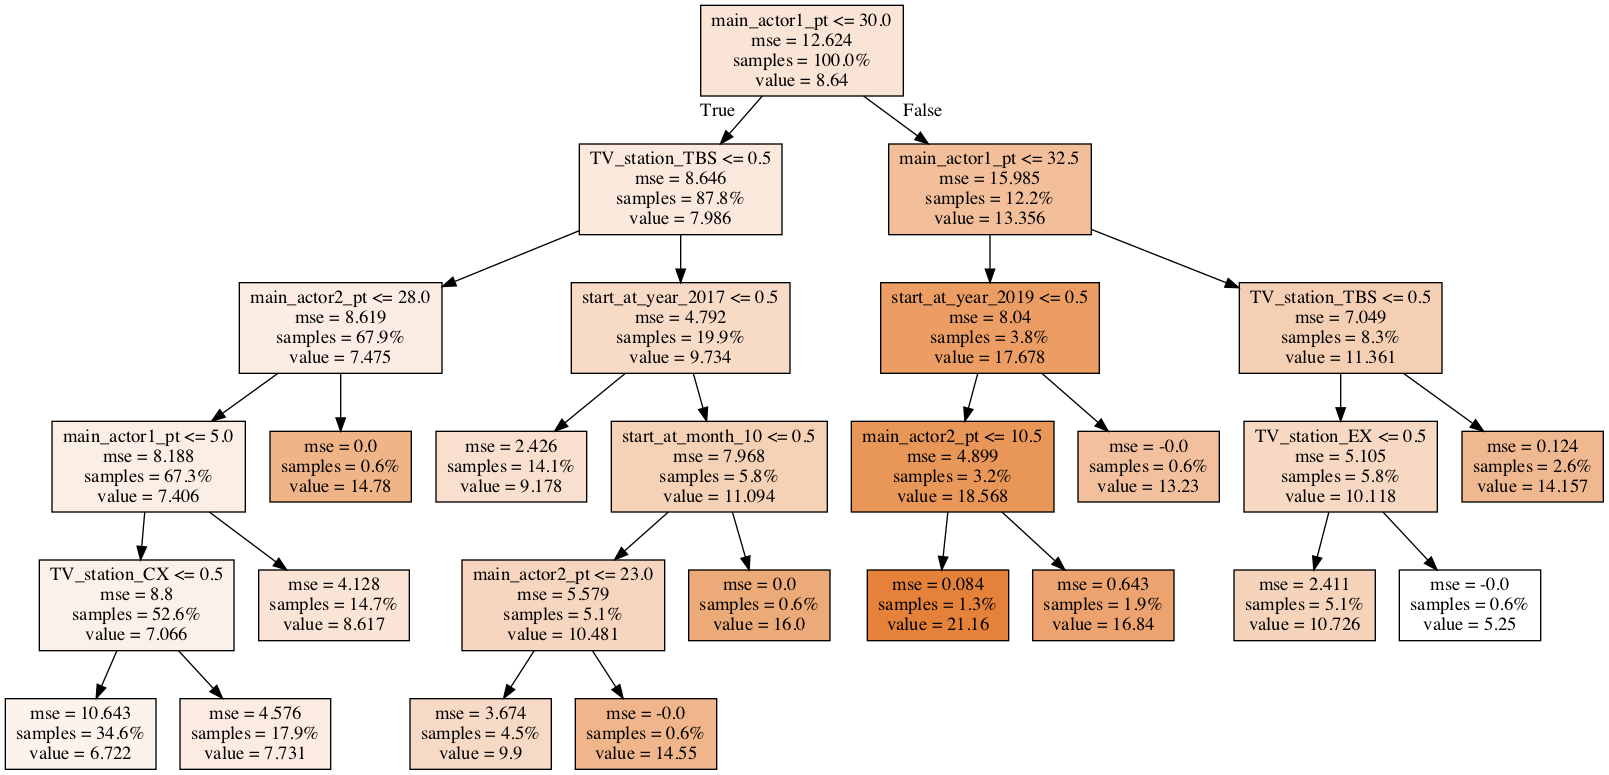

In [64]:
dot_data = tree.export_graphviz(
    clf,
    out_file=None,
    feature_names=X.columns,
    class_names="average",
    filled=True,
    proportion=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())